# Sonar Visualization Playground

Quick-start notebook to run the 2D sonar simulator, view wavefields inline, and export GIFs for report/presentation assets.

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML, Image

from setup_sonar_model import setup_sonar_model, print_model_info
from simpleLeapFrog import LeapfrogSolver
from sonar_viz import plot_pressure_xz_at
from create_wave_animation import create_wave_animation


## Run a baseline simulation
Configure a moderate grid and stable timestep (fraction of CFL). Adjust `Nx/Nz` or `t_extra` for larger domains or longer runs.

In [2]:
def run_simulation(Nx=201, Nz=51, Lx=5625, Lz=937.5, f0=20, t_extra=0.2, dt_scale=0.5):
    """Run sonar simulation and return state history"""
    model = setup_sonar_model(Nx=Nx, Nz=Nz, Lx=Lx, Lz=Lz, f0=f0, t_extra=t_extra)
    dt = dt_scale * model['max_dt_FE']
    num_steps = int(np.ceil((model['t_stop'] - model['t_start']) / dt))
    print_model_info(model, verbose=False)
    print(f"Using dt = {dt:.3e} s with {num_steps} steps")
    X, t = LeapfrogSolver(model['eval_f'], model['x_start'], model['p'], model['eval_u'], num_steps, dt, visualize=False, verbose=False)
    return {"model": model, "X": X, "t": t}

# Run a default scenario
sim = run_simulation()


SONAR MODEL CONFIGURATION

Grid: 201 × 51 = 10,251 cells
Domain: 5625m × 938m
Spacing: dx = 28.1250m, dz = 18.7500m

Acoustic Properties:
  Sound speed: c = 1500.0 m/s
  Frequency: f₀ = 20 Hz
  Wavelength: λ = 75.00m
  Resolution: 2.7 points per wavelength
  Domain coverage: 75.0λ × 12.5λ

Source Position:
  Grid indices: (100, 25)
  Physical: x = 2812.5m, z = 468.8m

Hydrophones: 5 receivers
  Type: Horizontal array at z = 468.8m
    H1: x = 928.1m
    H2: x = 1856.2m
    H3: x = 2812.5m
    H4: x = 3740.6m
    H5: x = 4668.8m

Time Integration:
  Time span: 0.000s to 3.950s (3950.0ms)
  Max stable dt (CFL): 4419.42 μs

State Vector: 20,502 DOFs
Using dt = 2.210e-03 s with 1788 steps
Running Leapfrog solver (stable for wave equations)...


## Single-frame snapshot
Inspect the pressure field at a chosen time (ms).

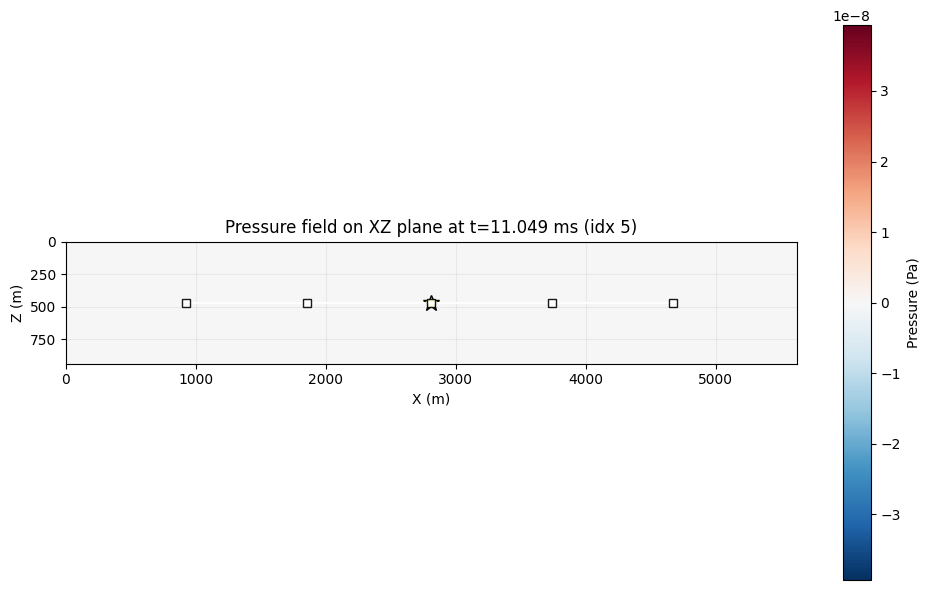

In [7]:
# Plot near the first surface reflection; tweak time_s as needed
_ = plot_pressure_xz_at(sim['model']['p'], sim['X'], sim['t'], time_s=0.01)


## Inline animation (HTML)
Lightweight animation for notebook viewing. Use `frame_skip` to trade fidelity for speed.

In [ ]:
def make_inline_animation(sim, frame_skip=1, interval=80, max_frames=300):
    p = sim['model']['p']
    X = sim['X']
    t = sim['t']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    pressure = X[:N, :].reshape(Nx, Nz, -1)
    total_frames = pressure.shape[2]

    v_abs = np.max(np.abs(pressure)) if pressure.size else 1.0
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(
        pressure[:, :, 0].T,
        extent=[0, p['Lx'], p['Lz'], 0],
        cmap='RdBu_r',
        vmin=-v_abs,
        vmax=v_abs,
        aspect='equal'
    )
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title('Wavefield animation')
    plt.close(fig)  # prevent duplicate static display

    def animate(i):
        frame = min(i * frame_skip, total_frames - 1)
        im.set_array(pressure[:, :, frame].T)
        ax.set_title(f't = {t[frame]*1000:.1f} ms')
        return [im]

    max_frames = min(max_frames, (total_frames + frame_skip - 1) // frame_skip)
    anim = animation.FuncAnimation(fig, animate, frames=max_frames, interval=interval, blit=True)
    return HTML(anim.to_jshtml())

# Display inline animation
make_inline_animation(sim, frame_skip=2, interval=60)


## Fast GIF writer (imageio)
Bypass Matplotlib animation and write frames directly. Adjust `frame_skip`/`max_frames`/`fps` to trade speed vs. smoothness.

In [ ]:
import imageio.v2 as imageio
import matplotlib.cm as cm

def save_gif_fast(sim, gif_path, frame_skip=4, max_frames=300, fps=12, cmap_name="RdBu_r"):
    p = sim['model']['p']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    pressure = sim['X'][:N, :].reshape(Nx, Nz, -1)
    v_abs = float(np.max(np.abs(pressure))) if pressure.size else 1.0
    cmap = cm.get_cmap(cmap_name)

    frames = []
    # Limit frames to keep runtime reasonable
    max_idx = min(pressure.shape[2], frame_skip * max_frames)
    for i in range(0, max_idx, frame_skip):
        frame = pressure[:, :, i].T
        norm = (frame + v_abs) / (2 * v_abs + 1e-12)  # map [-v_abs, v_abs] -> [0,1]
        rgba = (cmap(np.clip(norm, 0, 1)) * 255).astype(np.uint8)
        frames.append(rgba)

    imageio.mimsave(gif_path, frames, fps=fps)
    return gif_path

# Example fast export
os.makedirs('report/figs', exist_ok=True)
fast_gif_path = 'report/figs/sonar_wavefield_fast.gif'
save_gif_fast(sim, fast_gif_path, frame_skip=4, max_frames=400, fps=12)
Image(filename=fast_gif_path)


## Hydrophone traces
Plot pressure at the configured hydrophones to accompany animations.

In [ ]:
from eval_g_Sonar import eval_g_Sonar

def plot_hydrophones(sim, stride=1):
    p = sim['model']['p']
    t_full = sim['t']
    idx = np.arange(0, len(t_full), stride)
    t = t_full[idx]

    traces = []
    for i in idx:
        x_col = sim['X'][:, i].reshape(-1, 1)
        traces.append(eval_g_Sonar(x_col, p).reshape(-1))
    traces = np.stack(traces)

    plt.figure(figsize=(10, 5))
    for k in range(traces.shape[1]):
        plt.plot(t * 1000, traces[:, k], label=f'H{k+1}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Pressure (Pa)')
    plt.title('Hydrophone pressures')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

plot_hydrophones(sim, stride=1)


## (Optional) Notes
- Increase `Nx/Nz` or `t_extra` for higher-fidelity visuals; adjust `frame_skip` to keep animations responsive.
- Swap in `getParam_Absorb.py` (sponge/PML) inside `setup_sonar_model` if you prefer fewer boundary reflections for visuals.
- For MOR comparisons, run a reduced-order model separately and feed both `X` arrays into a modified animation that overlays or plots residuals.